# Analyzing Tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import collections
import datetime
import nltk
nltk.download(['stopwords'])
from nltk.corpus import stopwords
plt.style.use('fivethirtyeight')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bacher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# This function converts tweets databse CSV file into a dataframe and clean it for analysis
def create_df(csv_file, timezone, username, user_id):
    df = pd.read_csv(csv_file)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df=df[~df['date'].isna()]
    df['date'] = df['date'].dt.tz_convert(timezone)
    df.drop(['Unnamed: 0', 'url', 'media', 'mentionedUsers', 'source', 'sourceUrl', 'conversationId', '_type',
            'retweetedTweet', 'coordinates', 'content', 'outlinks', 'place', 'inReplyToTweetId', 'inReplyToUser', 
            'sourceLabel', 'tcooutlinks', 'lang', 'cashtags'], axis = 1, inplace = True)
    df.set_axis(['date', 'tweet', 'tweet_id', 'user', 'reply_count', 'retweet_count', 'like_count', 'quote_count', 'is_quote', 'hashtags'], axis=1, inplace=True)
    df['user'] = username

    df.loc[df['is_quote'].notnull(), 'is_quote'] = True
    df.loc[df['is_quote'].isnull(), 'is_quote'] = False
    df['is_quote'] = df['is_quote'].astype(bool)
    df['user_id'] = user_id

    df['time'] = pd.to_datetime(df['date']).dt.time
    return df

In [3]:
# Create the dataframe for the targeted users
df_cook = create_df('data/tim_cook_tweets.csv', 'US/Pacific', 'tim_cook', '1636590253')
df_musk = create_df('data/elon_musk_tweets.csv', 'US/Central', 'elon_musk', '44196397')
df_pichai = create_df('data/sundar_pichai_tweets.csv', 'US/Pacific', 'sundarpichai', '1')
df_jack = create_df('data/jack_tweets.csv', 'US/Pacific', 'jack', '2')
df_gates = create_df('data/bill_gates_tweets.csv', 'US/Pacific', 'BillGates', '3')


In [4]:
# This function gets basic statistical analysis from the dataframe
def get_stats(df, name):
    # Percentage of tweets that are retweets
    retweets = df[df['is_quote'] == True]
    retweets = round(len(retweets)/len(df_cook)*100)

    # Percentage of tweets that contain mentions
    mention_tweets = df[df['tweet'].str.contains("@")]
    mention_tweets = round(len(mention_tweets)/len(df_cook)*100)

    # Percentage of tweets that are normal tweets
    normal_tweets = (100 - retweets - mention_tweets)
    
    percentage = [retweets, mention_tweets, normal_tweets]
    return percentage

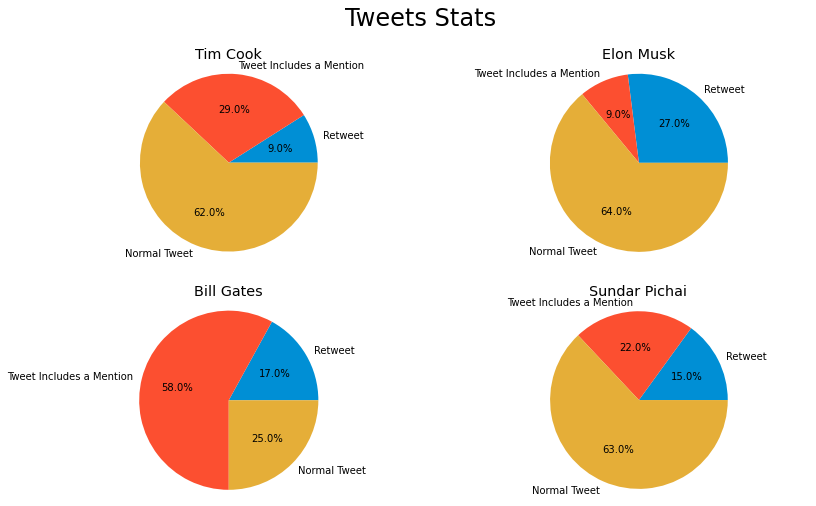

In [5]:
# Get the statistics for each user
get_stats(df_cook, "Tim Cook")
get_stats(df_musk, "Elon Musk")
get_stats(df_gates, "Bill Gates")
get_stats(df_pichai, "Sundar Pichai")

# Plot the findings
labels = 'Retweet', 'Tweet Includes a Mention', 'Normal Tweet'
fig, axs = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('Tweets Stats', fontsize=24)
fig.patch.set_facecolor('white')

sizes = get_stats(df_cook, "Tim Cook")
axs[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[0, 0].set_title("Tim Cook")
axs[0, 0].axis('equal')

sizes = get_stats(df_musk, "Elon Musk")
axs[0, 1].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[0, 1].set_title("Elon Musk")
axs[0, 1].axis('equal')

sizes = get_stats(df_gates, "Bill Gates")
axs[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[1, 0].set_title("Bill Gates")
axs[1, 0].axis('equal')

sizes = get_stats(df_pichai, "Sundar Pichai")
axs[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[1, 1].set_title("Sundar Pichai")
axs[1, 1].axis('equal')

plt.show();

In [6]:
# Function that gets the volume of the total tweets per each hour of the mean day
def tweet_hourly_volume(df, plot=False):
    # Define the list which will contain the tweets posted each day
    time_buckets = {
        '00':[],'01':[],'02':[],'03':[],'04':[],'05':[],'06':[],'07':[],'08':[],'09':[],'10':[],'11':[],
        '12':[],'13':[],'14':[],'15':[],'16':[],'17':[],'18':[],'19':[],'20':[],'21':[],'22':[],'23':[],
    }

    # Assing the tweets to their corresponding time bucket
    for tweet_id, time in zip(df['tweet'], df['time']):
        for key in time_buckets.keys():
            if datetime.time(int(key), 0, 0) <= time <= datetime.time(int(key), 59, 59):
                time_buckets[key].append(tweet_id)

    # Make a dictionary to store the ammount of tweets posted per hour
    #tweet_volume = time_buckets.copy()
    tweet_volume = {
        '00':[],'01':[],'02':[],'03':[],'04':[],'05':[],'06':[],'07':[],'08':[],'09':[],'10':[],'11':[],
        '12':[],'13':[],'14':[],'15':[],'16':[],'17':[],'18':[],'19':[],'20':[],'21':[],'22':[],'23':[],
    }

    # Count the amount of tweets per hour and add it as an integer to the dictionary
    for key, value in time_buckets.items():
        tweet_volume[key] = len(value)

    # Simple plot to visualize results
    if plot:
        plt.figure(figsize=(12, 8))
        plt.bar(range(len(tweet_volume)), list(tweet_volume.values()), align='center')
        plt.xticks(range(len(tweet_volume)), list(tweet_volume.keys()))
        plt.show()

    return tweet_volume

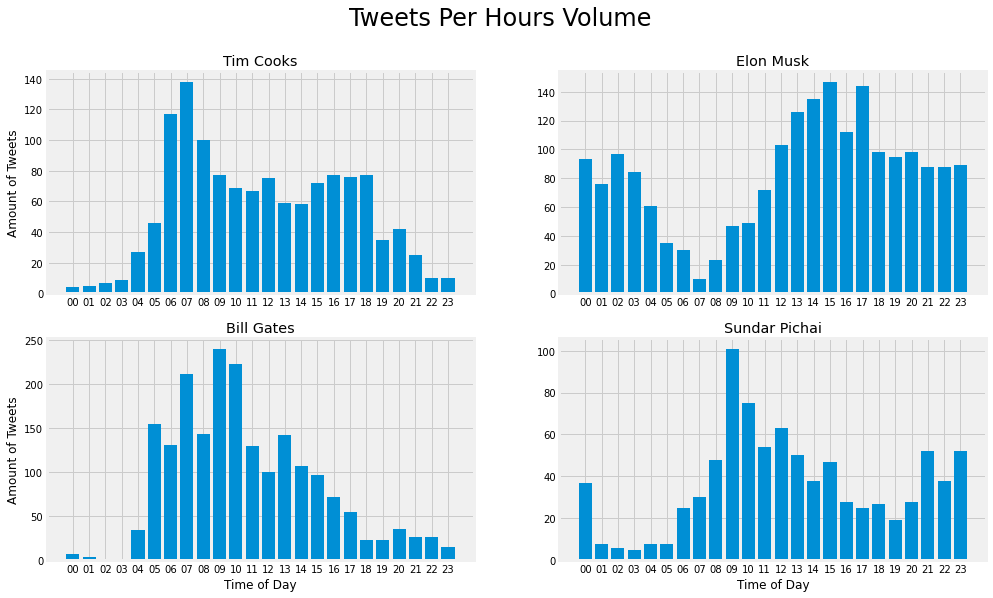

In [7]:
# Apply the function to each user
cook = tweet_hourly_volume(df_cook, False)
musk = tweet_hourly_volume(df_musk, False)
gates = tweet_hourly_volume(df_gates, False)
pichai = tweet_hourly_volume(df_pichai, False)

# Plot the data
fig, axs = plt.subplots(2, 2, figsize=(15,9))
fig.suptitle('Tweets Per Hours Volume', fontsize=24)

axs[0, 0].bar(range(len(cook)), list(cook.values()), align='center')
axs[0, 0].set_xticks(range(len(cook)), list(cook.keys()))
axs[0, 0].set_title("Tim Cooks")
axs[0, 0].set_ylabel("Amount of Tweets")


axs[0, 1].bar(range(len(musk)), list(musk.values()), align='center')
axs[0, 1].set_xticks(range(len(musk)), list(musk.keys()))
axs[0, 1].set_title("Elon Musk")

axs[1, 0].bar(range(len(gates)), list(gates.values()), align='center')
axs[1, 0].set_xticks(range(len(gates)), list(gates.keys()))
axs[1, 0].set_title("Bill Gates")
axs[1, 0].set_xlabel("Time of Day")
axs[1, 0].set_ylabel("Amount of Tweets")

axs[1, 1].bar(range(len(pichai)), list(pichai.values()), align='center')
axs[1, 1].set_xticks(range(len(pichai)), list(pichai.keys()))
axs[1, 1].set_title("Sundar Pichai")
axs[1, 1].set_xlabel("Time of Day")

plt.show();


In [8]:
# This function analyzes all the tweets, and using NLTK and collections it discards useless words and counts the most common words in the aglomeration of tweets
def get_common_words(df, plot=False):
    #Add all the tweets to a list
    tweets = []
    for tweet in df['tweet']:
        tweets.append(tweet)

    # Remove URLs, clean text, lower case, and split the strings into list of words
    def remove_url(txt):
        return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

    for i, tweet in enumerate(tweets):
        tweets[i] = remove_url(tweet).lower().split()
        continue

    # Remove stop words (useless words)
    stop_words = set(stopwords.words('english'))
    tweets = [[word for word in tweet_words if not word in stop_words]
                for tweet_words in tweets]

    # Romeve words from custom list of words (words that give no insights but common in the tweets)
    collection_words = ['im', 'amp', 'bloggoogleoutreachiniti', 'like', 'twittercomteslastatus1', 'twittercomspacexstatus', 'ive',
                        'tweeptour', 'twittercomsquarestatus', 'partythankyousatoshibitcoinorgbitcoinpdf', 'twittercomandrewjhowar', 'twittercomievents10356']
    tweets = [[w for w in word if not w in collection_words]
                    for word in tweets]

    # Get a count of all the words
    all_words = list(itertools.chain(*tweets))
    tweets_counter = collections.Counter(all_words)


    # Store the top most common words based on the counter to a DataFrame
    df_commons = pd.DataFrame(tweets_counter.most_common(15), columns=['words', 'count'])

    # Plot to review data
    if plot:
        fig, ax = plt.subplots(figsize=(8, 8))
        df_commons.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color="purple")
        ax.set_title("Common Words")
        plt.show()

    return df_commons

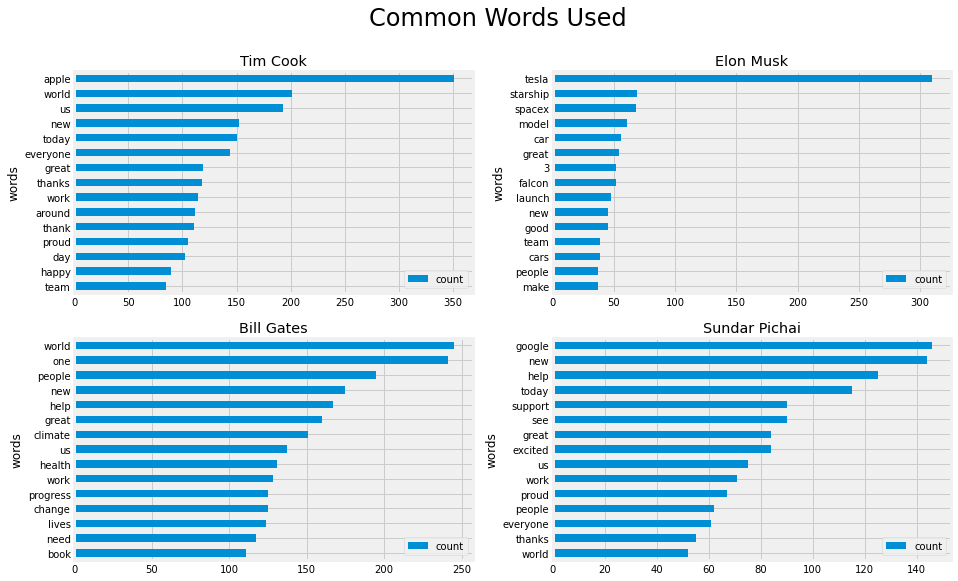

In [9]:
# Apply the function to the target users
cook = get_common_words(df_cook, False)
musk = get_common_words(df_musk, False)
gates = get_common_words(df_gates, False)
pichai = get_common_words(df_pichai, False)

# Plot the data
fig, axs = plt.subplots(2, 2, figsize=(14,9))
fig.suptitle('Common Words Used', fontsize=24)

cook.sort_values(by='count').plot.barh(x='words', y='count', ax=axs[0, 0])
axs[0, 0].set_title("Tim Cook")

musk.sort_values(by='count').plot.barh(x='words', y='count', ax=axs[0, 1])
axs[0, 1].set_title("Elon Musk")

gates.sort_values(by='count').plot.barh(x='words', y='count', ax=axs[1, 0])
axs[1, 0].set_title("Bill Gates")

pichai.sort_values(by='count').plot.barh(x='words', y='count', ax=axs[1, 1])
axs[1, 1].set_title("Sundar Pichai")

plt.show();

<h2 style="color:red">Following code still in developemnt</h2>

In [39]:
# This function combines the ideas of the functions get_common_words() and tweet_hourly_volume() to get the top 3 mean words tweeted per hour of the day
def time_buckets_words(df):
    # Define the list which will contain the tweets posted each day
    time_buckets = {
        '00':[],'01':[],'02':[],'03':[],'04':[],'05':[],'06':[],'07':[],'08':[],'09':[],'10':[],'11':[],
        '12':[],'13':[],'14':[],'15':[],'16':[],'17':[],'18':[],'19':[],'20':[],'21':[],'22':[],'23':[],
    }

    # Assing the tweets to their corresponding time bucket
    for tweet_id, time in zip(df['tweet'], df['time']):
        for key in time_buckets.keys():
            if datetime.time(int(key), 0, 0) <= time <= datetime.time(int(key), 59, 59):
                time_buckets[key].append(tweet_id)

    # Remove URLs, clean text, lower case, and split the strings into list of words
    def remove_url(txt):
        return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

    for key, value in time_buckets.items():
        for i, ele in enumerate(value):
            time_buckets[key][i] = remove_url(ele).lower().split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    for key, value in time_buckets.items():
        time_buckets[key] = [[word for word in tweet_words if not word in stop_words]
                for tweet_words in time_buckets[key]]

    # Remove stop words from custom list
    collection_words = ['im', 'amp', 'bloggoogleoutreachiniti', 'like', 'twittercomteslastatus1', 'twittercomspacexstatus', 'ive', 'twittercomteslaratistat',
                        'tweeptour', 'twittercomsquarestatus', 'partythankyousatoshibitcoinorgbitcoinpdf', 'twittercomsimongerman600',
                        'twittercomandrewjhowar', 'twittercomievents10356']
    for key, value in time_buckets.items():
        time_buckets[key] = [[w for w in word if not w in collection_words]
                for word in time_buckets[key]]


    # Copy to new dictionary, this one has the most comming Counter
    time_buckets_common = time_buckets.copy()

    for key, value in time_buckets.items():
        all_words = list(itertools.chain(*time_buckets[key]))
        time_buckets_common[key] = collections.Counter(all_words).most_common(3)


    # From here it needs more development
    # The idea is to get a stacked bar plot with three parts per bar, where each part is the volume per word
    #    The plot has a total of 24 value in the x axis for every hour of the day
    #
    #        | % 
    #        | % %   %       %
    #        | @ %   %   %   % % %
    #        | @ % % % % % % @ % % %
    #        | # % % @ % @ % @ % % %
    #        | # @ @ @ @ @ @ @ # @ %
    #        | # @ # @ @ # @ @ # @ @
    #        | # @ # @ @ # @ # # # @
    #        | # # # # # # @ # # # #    <---- Example of what I seek to achieve
    #        | # # # # # # # # # # #
    #         ______________________
    #

    # Create list with columns we need for dataframe
    columns = ['word']
    for x in range(1, 24):
        columns.append(x)
    
    df_c = pd.DataFrame(columns=columns)
    

    words = []
    counts = []
    
    for key, value in enumerate(time_buckets_common.items()):        
        for word, count in value[1]:
            words.append(word)
            counts.append(count)
        #df_c[str(key)] = count 
        print(key)
        continue

    # df_c = pd.DataFrame(columns=['time', 'words', 'count']) 
    
    # for key, value in enumerate(time_buckets_common.items()):
    #     word = []
    #     count = []
    #     for a, b in value[1]:
    #         word.append(a)
    #         count.append(b)
    #     df_c.loc[str(key)] = [key, word, count] 
    #     continue

    return words, counts
            

In [40]:
test = time_buckets_words(df_musk)
test

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


(['tesla',
  'use',
  'new',
  'tesla',
  'motor',
  'car',
  'tesla',
  'starship',
  'cant',
  'tesla',
  'giga',
  'time',
  'doo',
  'tesla',
  'doge',
  'love',
  'car',
  'tesla',
  'tesla',
  'non',
  'please',
  'everyone',
  'tesla',
  'left',
  'tesla',
  'car',
  'space',
  'tesla',
  'starship',
  'spacex',
  'tesla',
  'spacex',
  'stock',
  'tesla',
  'coming',
  'landing',
  'tesla',
  'good',
  'launch',
  'tesla',
  'important',
  'starship',
  'tesla',
  'cant',
  'cars',
  'tesla',
  'team',
  '3',
  'tesla',
  'great',
  'spacex',
  'tesla',
  'test',
  'rocket',
  'tesla',
  'model',
  'falcon',
  'tesla',
  'starlink',
  'want',
  'tesla',
  'great',
  '1',
  'tesla',
  'spacex',
  'much',
  'tesla',
  'super',
  'starship',
  'tesla',
  'model',
  '3'],
 [9,
  3,
  3,
  11,
  7,
  5,
  7,
  7,
  4,
  6,
  3,
  3,
  12,
  6,
  5,
  3,
  3,
  2,
  3,
  2,
  2,
  3,
  3,
  2,
  6,
  5,
  3,
  10,
  4,
  4,
  6,
  3,
  3,
  13,
  6,
  5,
  17,
  7,
  7,
  26,
  6,
  

In [13]:
#test = test.astype(int)
test.plot.bar(stacked=True, color=['red', 'pink']) #xticks=stacked['time'], yticks=stacked['count'], 
 
# Add Title and Labels
plt.title('Title')
plt.xlabel('X')
plt.ylabel('Y')

AttributeError: 'dict' object has no attribute 'plot'